#  **BUILD DECISION TREE FOR BREAST CANCER DATASET ON SKLEARN**
---

Import necessary library

In [155]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from sklearn.tree import DecisionTreeClassifier, export_graphviz

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
from IPython.display import Image

%matplotlib inline

## 1. LOAD DATASET

In [156]:
breast_cancer = load_breast_cancer()
X = breast_cancer.data 
y = breast_cancer.target 
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

df = pd.DataFrame(X, columns=feature_names)
df['Label'] = y
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## 2. SPLIT DATA INTO TRAIN/TEST SETS

In [157]:
ratios = [0.4, 0.6, 0.8, 0.9] # train ratio
datasets = {}

class_distributions = {'original': y}

In [158]:
def split_train_test(X, y, ratio, stratify=True):
    if stratify:
        stratify_param = y
    else:
        stratify_param = None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 - ratio, random_state=42, stratify=stratify_param
    )

    return X_train, X_test, y_train, y_test

In [159]:
for ratio in ratios:
    X_train, X_test, y_train, y_test = split_train_test(X, y, ratio)
    datasets[f'{int(ratio*100)}_train'] = (X_train, y_train)
    datasets[f'{100 - int(ratio*100)}_test'] = (X_test, y_test)
    class_distributions[f'{int(ratio*100)}_train'] = y_train
    class_distributions[f'{100 - int(ratio*100)}_test'] = y_test

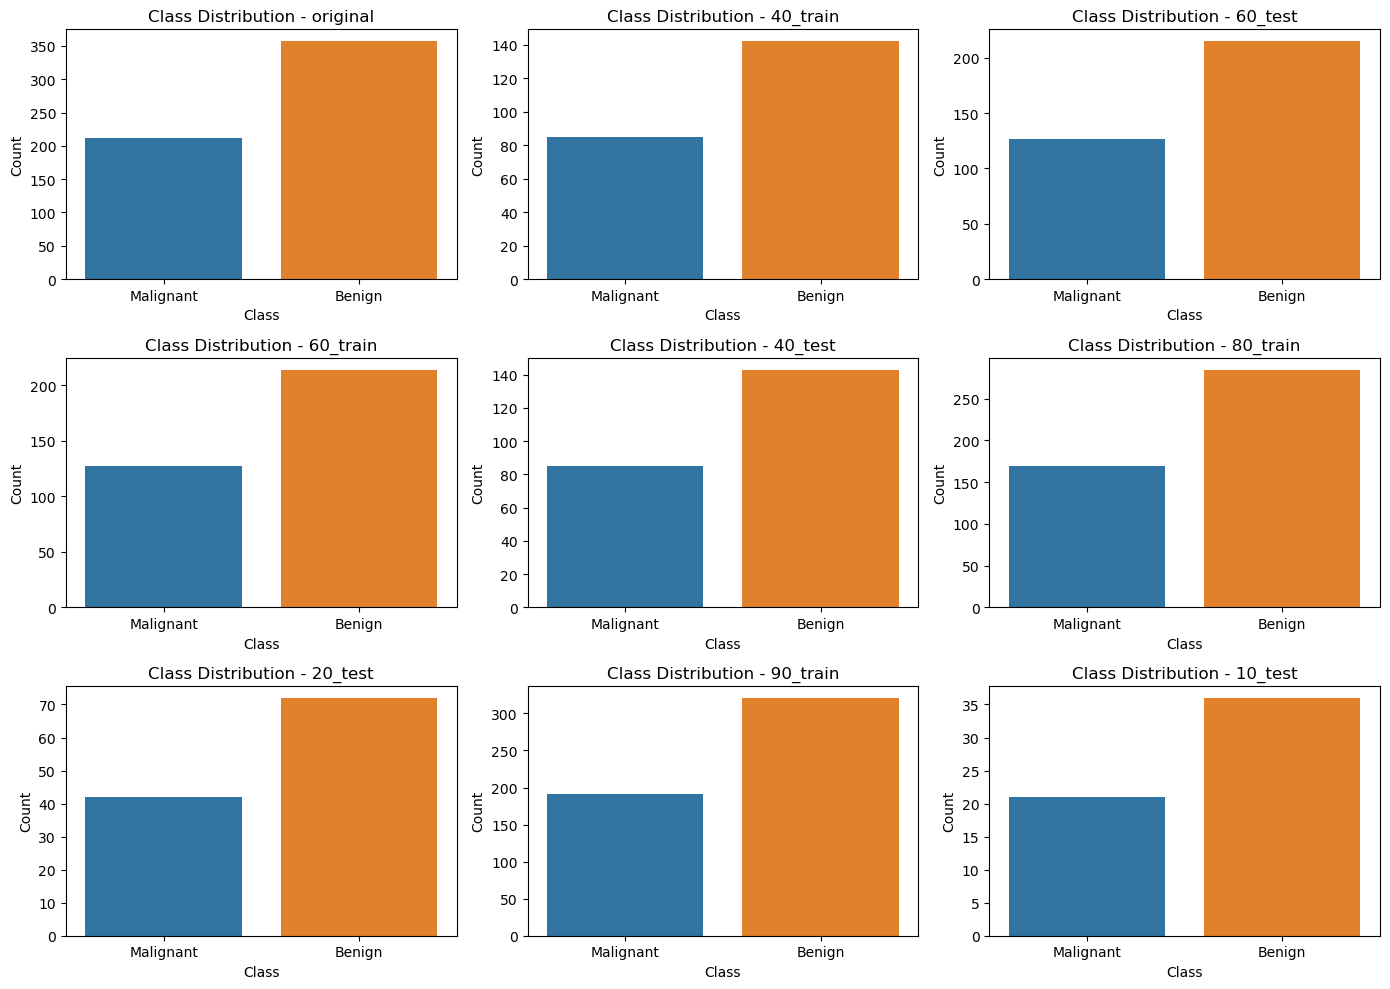

In [160]:
plt.figure(figsize=(14, 10))
for i, (key, y_values) in enumerate(class_distributions.items()):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=y_values)
    plt.title(f'Class Distribution - {key}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'])

plt.tight_layout();

- ...

## 3. BUILD DECISION TREE

In [162]:
class Node:
    def __init__(self, feature=None, threshold=None, entropy=None, samples=None, value=None, class_label=None):
        self.feature = feature          # Thuộc tính phân chia tại node
        self.threshold = threshold      # Ngưỡng để phân chia
        self.entropy = entropy          # Độ hỗn loạn (entropy hoặc gini)
        self.samples = samples          # Số lượng mẫu tại node
        self.value = value              # Phân phối các lớp [số mẫu lớp 0, số mẫu lớp 1, ...]
        self.class_label = class_label  # Lớp chiếm đa số tại node

        self.left = None                # Nhánh trái
        self.right = None               # Nhánh phải

    def is_leaf(self):
        """Kiểm tra nếu node là node lá."""
        return self.left is None and self.right is None

    def summary(self):
        """Trả về chuỗi tóm tắt để hiển thị trên Graphviz."""
        class_name = target_names[self.class_label]
        feature_name = feature_names[self.feature]

        if self.is_leaf():
            return f"entropy = {self.entropy:.3f}\nsamples = {self.samples}\nvalue = {self.value}\nclass = {class_name}"
        else:
            return f"{feature_name} ≤ {self.threshold}\nentropy = {self.entropy:.3f}\nsamples = {self.samples}\nvalue = {self.value}\nclass = {class_name}"


In [163]:
class DecisionTree:
    def __init__(self, max_depth=None, min_sample_leaf = 1):
        self.max_depth = max_depth
        self.root = None

    def entropy(self, y) -> float:
        if len(y) == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))
    
    def information_gain(self, y, y_left, y_right):
        entropy_before = self.entropy(y)
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        entropy_after = weight_left * self.entropy(y_left) + weight_right * self.entropy(y_right)
        gain = entropy_before - entropy_after
        return gain
    
    def split(self, X, slitColumnIdx, splitValue):
        splitColumnValues = X[:, slitColumnIdx]
        return X[splitColumnValues <= splitValue], X[splitColumnValues > splitValue]

    def find_best_split(self, X, y):
        """Tìm thuộc tính và ngưỡng tốt nhất để phân chia tập dữ liệu."""
        best_feature, best_threshold = None, None
        best_gain = -1
        n_samples, n_features = X.shape
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]

                gain = self.information_gain(y, left_y, right_y)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth=0, max_depth=None):
        """Đệ quy xây dựng cây quyết định."""
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        
        # Tạo root
        node = Node(
            entropy=self.entropy(y),
            samples=num_samples,
            value=np.bincount(y, minlength=num_classes),
            class_label=np.argmax(np.bincount(y, minlength=num_classes))
        )
        
        # Điều kiện dừng
        if num_classes == 1 or num_samples <= 1 or (max_depth is not None and depth >= max_depth):
            return node
                
        # Tìm thuộc tính và ngưỡng tốt nhất
        feature, threshold, gain = self.find_best_split(X, y)
        if gain == 0:
            return node
        
        # Phân chia dữ liệu
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        left_X, left_y = X[left_mask], y[left_mask]
        right_X, right_y = X[right_mask], y[right_mask]
        
        # Cập nhật thông tin cho node
        node.feature = feature
        node.threshold = threshold
        
        # Đệ quy tạo các node con
        node.left = self.build_tree(left_X, left_y, depth + 1, max_depth)
        node.right = self.build_tree(right_X, right_y, depth + 1, max_depth)
        
        return node

    def fit(self, X, y):
        """Huấn luyện cây quyết định."""
        self.root = self.build_tree(X, y, max_depth=self.max_depth)

    def predict_1sample(self, x, node):
        """Duyệt cây để dự đoán một mẫu."""
        if node.is_leaf():
            return node.class_label  # Trả về lớp có nhiều mẫu nhất

        # Điều hướng qua cây dựa trên feature và threshold
        if x[node.feature] <= node.threshold:
            return self.predict_1sample(x, node.left)
        else:
            return self.predict_1sample(x, node.right)
        
    def predict(self, X):
        """Dự đoán đầu ra cho tập dữ liệu."""
        return np.array([self.predict_1sample(x, self.root) for x in X])    

Test thử cho tập 40 train

In [165]:
X_train_40 = datasets['40_train'][0]
y_train_40 = datasets['40_train'][1]
X_test_60 = datasets['60_test'][0]
y_test_60 = datasets['60_test'][1]

dt = DecisionTree()
dt.fit(X_train_40, y_train_40)
y_predict_60 = dt.predict(X_test_60)

print("Accuracy:", accuracy_score(y_test_60, y_predict_60))

Accuracy: 0.9035087719298246


In [166]:
report = classification_report(y_predict_60, y_test_60, target_names=target_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

   malignant       0.91      0.85      0.87       136
      benign       0.90      0.94      0.92       206

    accuracy                           0.90       342
   macro avg       0.90      0.89      0.90       342
weighted avg       0.90      0.90      0.90       342



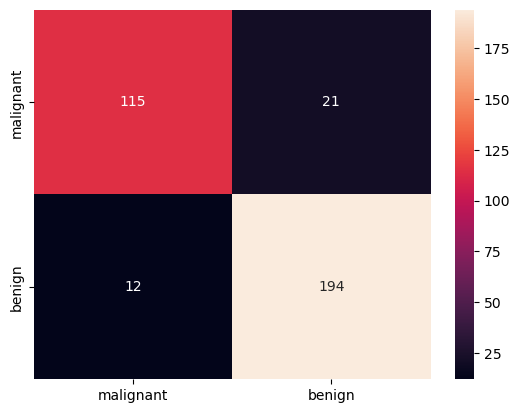

In [167]:
matrix = confusion_matrix(y_predict_60, y_test_60)
sns.heatmap(matrix, annot=True, fmt = 'd', xticklabels=target_names, yticklabels=target_names);

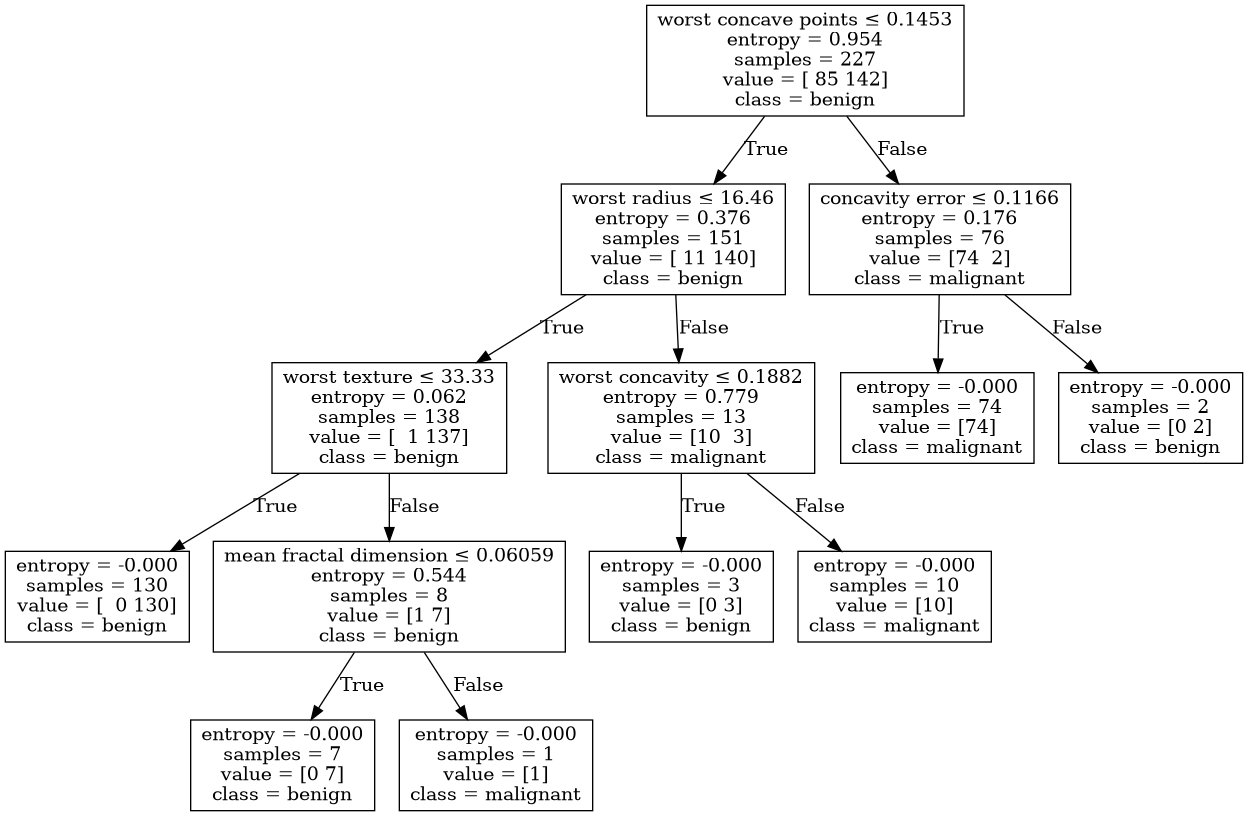

In [169]:
def visualize_tree(node, graph=None, parent=None, edge_label=""):
    """
    Chuyển đổi cây quyết định từ Node thành định dạng Graphviz.
    :param node: Node gốc của cây
    :param graph: Đối tượng Graphviz Digraph
    :param parent: Node cha trong đồ thị
    :param edge_label: Nhãn cạnh nối từ parent tới node
    """
    if graph is None:
        graph = Digraph()
        graph.attr("node", shape="box")

    # Tạo nút cho node hiện tại
    node_label = node.summary()  # Tóm tắt thông tin node
    current_node_id = str(id(node))
    graph.node(current_node_id, node_label)

    # Nếu có parent, vẽ cạnh nối
    if parent is not None:
        graph.edge(str(id(parent)), current_node_id, label=edge_label)

    # Nếu không phải node lá, đệ quy vẽ tiếp
    if not node.is_leaf():
        visualize_tree(node.left, graph, node, edge_label=f"True")
        visualize_tree(node.right, graph, node, edge_label=f"False")

    return graph

tree_graph = visualize_tree(dt.root)
tree_graph.render("decision_tree", format="png", cleanup=True)
Image("decision_tree.png")